##Data load

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/CollabData/hatedata/errortest.csv')

In [ ]:
# df.head()

In [ ]:
# df.tail()

## Preprocess data

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [5]:
texts = df['comment_text']
labels = df[df.columns[2:]].values

In [6]:
MAX_FEATURES = 150000

In [7]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length = 1000,
                               output_mode ='int')

In [8]:
vectorizer.adapt(texts.values)

In [9]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'i',
 'of',
 'and',
 'you',
 'a',
 'is',
 'that',
 'it',
 'in',
 'for',
 'this',
 'not',
 'on',
 'be',
 's',
 'as',
 'have',
 'are',
 'your',
 't',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'wikipedia',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'can',
 'talk',
 'me',
 'about',
 'so',
 'what',
 'there',
 'all',
 'has',
 'will',
 'please',
 'no',
 'they',
 'would',
 'he',
 'one',
 'like',
 'just',
 'we',
 'which',
 'any',
 'been',
 'should',
 'don',
 'more',
 'some',
 'other',
 'here',
 'who',
 'see',
 'also',
 'his',
 'm',
 'fuck',
 'think',
 'because',
 'know',
 'how',
 'people',
 'am',
 'edit',
 'why',
 'up',
 'only',
 'out',
 'articles',
 'use',
 'when',
 'then',
 'time',
 'may',
 'were',
 'block',
 'did',
 'them',
 'now',
 'user',
 'being',
 'their',
 're',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'well',
 'very',
 've',
 'information',
 'does',
 'could',
 'want',
 'deletion',
 'its',
 'such',
 'sources',
 '

In [10]:
vectorizer.text = vectorizer(texts.values)

In [11]:
vectorizer.text

<tf.Tensor: shape=(159571, 1000), dtype=int64, numpy=
array([[  668,    79,     2, ...,     0,     0,     0],
       [  146, 15757,    52, ...,     0,     0,     0],
       [  407,   416,     4, ...,     0,     0,     0],
       ...,
       [28310,  6902,  4876, ...,     0,     0,     0],
       [    6,    11,   566, ...,     0,     0,     0],
       [    6,     4,   139, ...,     0,     0,     0]])>

**Data pipeline** -- map, cache, shuffle, batch, prefetch

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((vectorizer.text, labels))

In [13]:
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) #prevents bottlenecks

In [ ]:
# dataset

In [ ]:
# dataset.as_numpy_iterator().next()

In [14]:
#splitting train and validation data
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.3))
# test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
# # preprocess test data
# # Read the test data
# df_test = pd.read_csv('/content/drive/My Drive/CollabData/hatedata/test.csv')

# # Extract text and labels
# labels_test = df_test[df_test.columns[2:]].values
# texts_test = df_test['comment_text']

# # Use the same vectorizer on the test data
# vectorized_texts_test = vectorizer(texts_test.values)

# # Create a separate Dataset for the test data
# dataset_test = tf.data.Dataset.from_tensor_slices((vectorized_texts_test, labels_test))
# dataset_test = dataset_test.cache()
# dataset_test = dataset_test.shuffle(160000)  # Adjust the shuffle size if needed
# dataset_test = dataset_test.batch(16)
# dataset_test = dataset_test.prefetch(8)

In [ ]:
# dataset_test.as_numpy_iterator().next()

In [ ]:
# df_test.head()

In [15]:
train_generator = train.as_numpy_iterator()
train_generator.next()

(array([[  643, 13630,     6, ...,     0,     0,     0],
        [ 1260,     5,   571, ...,     0,     0,     0],
        [   63,   115,  1184, ...,     0,     0,     0],
        ...,
        [  407,    22,    26, ...,     0,     0,     0],
        [ 1961,  1204,     2, ...,     0,     0,     0],
        [  455,     4,    67, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

##Seq Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2

dropout_rate = 0.01
l2_lambda = 0.01

In [17]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda)))
model.add(BatchNormalization())
model.add(Dropout(rate=dropout_rate))

model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_lambda)))
model.add(BatchNormalization())
model.add(Dropout(rate=dropout_rate))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda)))
model.add(BatchNormalization())
model.add(Dropout(rate=dropout_rate))

model.add(Dense(6, activation='sigmoid'))

In [18]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          4800032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               3

In [20]:
history = model.fit(train, epochs = 5, validation_data = val)

Epoch 1/5
6981/6981 [==============================] - 561s 79ms/step - loss: 0.1537 - val_loss: 0.4080
Epoch 2/5
6981/6981 [==============================] - 455s 65ms/step - loss: 0.0598 - val_loss: 0.0839
Epoch 3/5
6981/6981 [==============================] - 453s 65ms/step - loss: 0.0515 - val_loss: 0.0687
Epoch 4/5
6981/6981 [==============================] - 443s 63ms/step - loss: 0.0474 - val_loss: 0.0424
Epoch 5/5
6981/6981 [==============================] - 441s 63ms/step - loss: 0.0443 - val_loss: 0.0438


In [21]:
history.history

{'loss': [0.1537008136510849,
  0.05978008359670639,
  0.05154312402009964,
  0.04737783223390579,
  0.04428046941757202],
 'val_loss': [0.40804609656333923,
  0.08387283235788345,
  0.06870430707931519,
  0.04244124889373779,
  0.043845150619745255]}

In [22]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

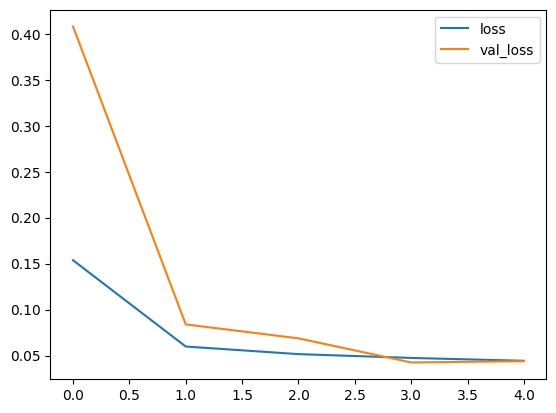

In [23]:
d_f = pd.DataFrame(history.history)
plt.figure(figsize=(8,5))
d_f.plot()
plt.show()

##Prediction

In [24]:
input_text = vectorizer("I will shoot you and your family")

In [ ]:
# batch_X, batch_y = test.as_numpy_iterator().next()

In [25]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [26]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 827ms/step


array([[0.726875  , 0.00303764, 0.09992456, 0.00966968, 0.13229103,
        0.01707389]], dtype=float32)

In [ ]:
# res = model.predict(np.expand_dims(input_text,0))

In [ ]:
# from tensorflow.keras.models import load_model

# model.save('/content/drive/My Drive/CollabData/hatedata/model_20.h5')

In [ ]:
# model = load_model("...") #insert model path here

In [27]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [28]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [29]:
test_df = pd.read_csv('/content/drive/MyDrive/CollabData/hatedata/train.csv')

In [30]:
X = test_df['comment_text']
Y = test_df[test_df.columns[2:].values]

In [31]:
vectorized_text = vectorizer(X.values)

In [32]:
test_dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, Y))
test_dataset = test_dataset.cache()
test_dataset = test_dataset.shuffle(160000)
test_dataset = test_dataset.batch(16)
test_dataset = test_dataset.prefetch(8)

In [33]:
test = test_dataset.take(int(len(dataset)*.4))

In [34]:
for batch in test.as_numpy_iterator():

    X_true, y_true = batch

    yhat = model.predict(X_true)

    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 51ms/step


In [35]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9237437844276428, Recall:0.45171719789505005, Accuracy:0.4830784797668457
